# Classifying newswires : A Multi-Class

In [1]:
from keras.datasets import reuters


Using TensorFlow backend.


In [2]:
(train_data, train_labels),(test_data,test_labels) = reuters.load_data(num_words=10000)
word_index = reuters.get_word_index()

In [3]:
train_data.shape

(8982,)

In [4]:
train_data[0]

[1,
 2,
 2,
 8,
 43,
 10,
 447,
 5,
 25,
 207,
 270,
 5,
 3095,
 111,
 16,
 369,
 186,
 90,
 67,
 7,
 89,
 5,
 19,
 102,
 6,
 19,
 124,
 15,
 90,
 67,
 84,
 22,
 482,
 26,
 7,
 48,
 4,
 49,
 8,
 864,
 39,
 209,
 154,
 6,
 151,
 6,
 83,
 11,
 15,
 22,
 155,
 11,
 15,
 7,
 48,
 9,
 4579,
 1005,
 504,
 6,
 258,
 6,
 272,
 11,
 15,
 22,
 134,
 44,
 11,
 15,
 16,
 8,
 197,
 1245,
 90,
 67,
 52,
 29,
 209,
 30,
 32,
 132,
 6,
 109,
 15,
 17,
 12]

In [5]:
reverse_word_index = dict([(i,j) for j,i in word_index.items()])    

In [6]:
def decode(message):
    result = ''
    for i in message:
        result = result + reverse_word_index.get(i-3,'?')+' '
    return result

In [7]:
decode(train_data[0])

'? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3 '

Trừ 3 khi lấy word từ index vì 3 kí tự đầu tiên : 0,1,2 được kí hiệu cho padding, start of sequence và unknown

In [8]:
train_labels[0]

3

### Ta sẽ encode data như ví dụ binary-classify 

In [9]:
import numpy as np

In [10]:
def vectorize_sequences(sequences, dim = 10000):
    results = np.zeros((len(sequences),dim))
    for i, seq in enumerate(sequences):
        results[i,seq] = 1
    return results

In [11]:
x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

In [29]:
print(x_train)
print('shape of x_train after one-hot : ',x_train.shape)

[[ 0.  1.  1. ...,  0.  0.  0.]
 [ 0.  1.  1. ...,  0.  0.  0.]
 [ 0.  1.  1. ...,  0.  0.  0.]
 ..., 
 [ 0.  1.  1. ...,  0.  0.  0.]
 [ 0.  1.  1. ...,  0.  0.  0.]
 [ 0.  1.  1. ...,  0.  0.  0.]]
shape of x_train after one-hot :  (8982, 10000)


In [13]:
train_labels

array([ 3,  4,  3, ..., 25,  3, 25])

In [14]:
train_labels.shape

(8982,)

In [15]:
count_word = {}

In [16]:
for i in train_labels:
    if i not in count_word:
        count_word[i] = 1
    else :
        count_word[i] += 1

In [17]:
len(count_word)

46

In [18]:
# ta sẽ encode label theo kiểu one-hot
def one_hot_label(labels, dim = len(count_word)):
    results = np.zeros((len(labels), dim))
    for i,label in enumerate(labels):
        # nếu label thứ i là true -> 1
        results[i,label] = 1
    return results
    

In [23]:
one_hot_train_labels = one_hot_label(train_labels)
one_hot_test_labels = one_hot_label(test_labels)
print(one_hot_train_labels.shape)

(8982, 46)


In [24]:
# Trong keras cũng có sẵn hàm convert one-hot : 
from keras.utils.np_utils import to_categorical
# COnvert class vector sang kieu one-hot

In [25]:
one_hot_train_labels

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [26]:
one_hot_train_labels = to_categorical(train_labels)
one_hot_test_labels = to_categorical(test_labels)

In [27]:
one_hot_train_labels.shape

(8982, 46)

## Let's build our network

Bài tập này khá tương đồng với bài trước : Ta có 1 list tin ngắn đã được encode và có 1 list label </br>
Điểm khác biệt là label có tất cả 46 giá trị thay vì 2 ( tốt - xấu ) như bài tập trước 

Sử dụng 16 hidden units trong 1 layer như bài tập trước sẽ không ổn vì các lý do sau :
- 1 Dense layer chỉ tiếp nhận information truyền từ layer trước -> nếu layer i <b>loại bỏ 1 số đặc tính liên quan đến bài toán phân loại </b> thì layer i+1 sẽ <b>không thể recover lại </b> thông tin đó 
- dim = 16 sẽ bị giới hạn với 46 labels (<b>bottle-necks</b>), có thể sẽ drop 1 số đặc tính quan trọng

In [28]:
# Ta sẽ dùng dense layer với 64 hidden units
from keras import models
from keras import layers

model = models.Sequential()
# 2 hidden Dense layers with 64 hidden units
model.add(layers.Dense(64,activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64,activation='relu'))
# output layer : co 46 kha nang out-put, su dung activation softmax
model.add(layers.Dense(46,activation='softmax'))

Có một số điểm ta cần lưu ý : 
- output layer là 1 dense layer với size =46 -> với mỗi input, network sẽ trả về <b>1 vector với dim=46</b>, mỗi index tượng trưng cho output của mỗi class
- softmax activation : trả về phân phối xác suất (<b>probability distribution</b>) trên 46 classes khác nhau</br>

Để dễ hình dung : 
- output[i] là khả năng sample thuộc class i
- tổng 46 output = 1

Loss function phù hợp nhất là <b> categorical-cross entropy </b> : Thể hiện độ lệch của phân phối xác suất của output và label đúng của sample đó ( bằng cách train, ta sẽ giảm khoảng cách của output với ground truth của nó )

In [31]:
model.compile(optimizer='rmsprop',
             loss='categorical_crossentropy',
             metrics=['accuracy'])

## Tạo validation set

In [32]:
# ta sẽ để 1000 samples làm validation set
x_val= x_train[:1000] # 1000 sample đầu tiên
partial_x_train = x_train[1000:]

y_val = one_hot_train_labels[:1000]
partial_y_train = one_hot_train_labels[1000:]


## Training Time :D We all love it

In [33]:
history = model.fit(partial_x_train,partial_y_train, batch_size=512, epochs=20,
                   validation_data=(x_val,y_val))

Train on 7982 samples, validate on 1000 samples
Epoch 1/20
7982/7982 [==============================] - 17s - loss: 2.5306 - acc: 0.4962 - val_loss: 1.7180 - val_acc: 0.6120
Epoch 2/20
7982/7982 [==============================] - 1s - loss: 1.4430 - acc: 0.6878 - val_loss: 1.3435 - val_acc: 0.7060
Epoch 3/20
7982/7982 [==============================] - 1s - loss: 1.0929 - acc: 0.7661 - val_loss: 1.1704 - val_acc: 0.7430
Epoch 4/20
7982/7982 [==============================] - 1s - loss: 0.8682 - acc: 0.8166 - val_loss: 1.0788 - val_acc: 0.7600
Epoch 5/20
7982/7982 [==============================] - 1s - loss: 0.7020 - acc: 0.8483 - val_loss: 0.9844 - val_acc: 0.7830
Epoch 6/20
7982/7982 [==============================] - 1s - loss: 0.5666 - acc: 0.8796 - val_loss: 0.9401 - val_acc: 0.8030
Epoch 7/20
7982/7982 [==============================] - 0s - loss: 0.4592 - acc: 0.9039 - val_loss: 0.9090 - val_acc: 0.8010
Epoch 8/20
7982/7982 [==============================] - 0s - loss: 0.3704 - 

### Display quá trình train 

In [34]:
import matplotlib.pyplot as plt

%matplotlib inline

In [36]:
history.history

{'acc': [0.49624154359229194,
  0.68779754559517625,
  0.76609872276697566,
  0.81658732095059816,
  0.84828363894759129,
  0.87960411000747607,
  0.90390879447464356,
  0.92257579542048684,
  0.93084439919784057,
  0.94124279726241589,
  0.94713104376067681,
  0.95114006543034035,
  0.95226760258264809,
  0.9553996486133336,
  0.95552493108002889,
  0.9561513398142274,
  0.95765472233549331,
  0.95815585006660342,
  0.95953395079323833,
  0.95953395079323833],
 'loss': [2.5306202336918049,
  1.442997769704889,
  1.0929249797480294,
  0.86820351209774316,
  0.70198449548459896,
  0.56661342454416597,
  0.45916152032536989,
  0.37039464380591175,
  0.30363121428635448,
  0.25392186253389243,
  0.21847642021754488,
  0.18715875964883394,
  0.16961247349809924,
  0.15311522225528934,
  0.13867348057304937,
  0.1310018641709445,
  0.12135314796352351,
  0.11931173248947846,
  0.11355127742179383,
  0.11040981212853489],
 'val_acc': [0.61200000095367435,
  0.70600000667572016,
  0.743000000

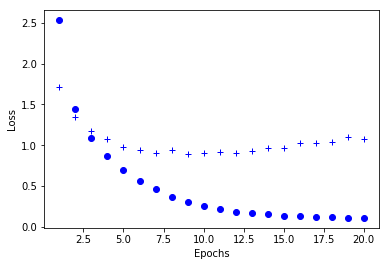

In [38]:
history_dict = history.history # trả về dict các giá trị 
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = range(1, len(loss)+1)
# plot training & validation loss 
plt.plot(epochs, loss, 'bo')
plt.plot(epochs, val_loss, 'b+')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.show()


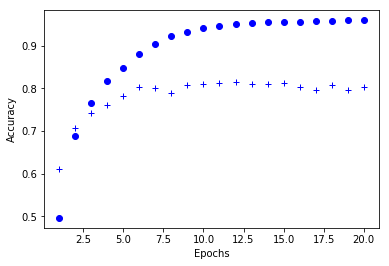

In [39]:
# plot training & validation accuracy :
plt.clf()
plt.plot(epochs, history_dict['acc'], 'bo')
plt.plot(epochs, history_dict['val_acc'],'b+')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [40]:
import copy

In [41]:
# Độ chính xác khi random
test_labels_copy = copy.copy(test_labels)
np.random.shuffle(test_labels_copy)
float(np.sum(np.array(test_labels) == np.array(test_labels_copy))) / len(test_labels)

0.1834372217275156

In [42]:
model.evaluate(x_test,one_hot_test_labels)

2080/2246 [==========================>...] - ETA: 0s

[1.2140142543976156, 0.77871772044488397]

#### Model của chúng ta có accuracy ~ 78%, lớn hơn rất nhiều so với random ( 19%)

## Predict với data mới 

In [43]:
predictions = model.predict(x_test)
predictions[0].shape

(46,)

In [45]:
np.sum(predictions[0])
# Tổng probability distribution ouput của mỗi sample = 1

1.0000001

In [50]:
# Kết quả predict là class có giá trị cao nhất
np.argmax(predictions[0])

3

In [51]:
np.argmax(one_hot_test_labels[0])

3